In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [ ]:
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

#### Download Images

In [5]:
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

#### Load images, convert to tensors and resize.

In [6]:
def load_image(path_to_image):
    max_dim = 512 #512-256-128-64-32
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3) #take image file and convert to tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

#### Display Images

In [7]:
def image_show(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

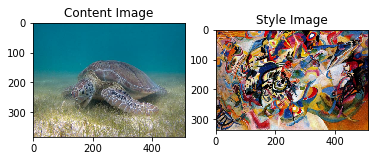

In [32]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1,2,1)
image_show(content_image, 'Content Image')

plt.subplot(1,2,2)
image_show(style_image, 'Style Image')

#### Load pretrained model (VGG19)  with weight that were trained on imagenet.  We will be using intermediate layers to extract the "style" and "content" from our images.  Test model on content image (turtle) to see if it is working correctly.

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
r = vgg(x)

In [10]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[np.argsort(r)[0, ::-1][:5]+1])

['loggerhead' 'leatherback turtle' 'hermit crab' 'terrapin' 'mud turtle']


##### ^ It classifies our turtle as a turtle!  VGG19 is pretty good!

#### Visualize the layers of VGG19 model.

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### We will use one of the later layers to extract out 'content'.  The deeper layers will detect high level textures features.  This is good for understanding the actual content of an image.

#### We will use multiple layers to try and understand the 'style' of our style image.  The earlier layers will detect simple things like edges, but we also want to be able to represent higher level features, so we will use deeper layers as well.

In [12]:
#Content layers
content_layers = ['block5_conv2']

#Style Layer
style_layers = ['block1_conv1', 'block3_conv1',]
#, 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Build model.

In [13]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

#### Create model.  Print shapes from each of the 'style' layers.  As is typical of most CNN's, the deeper into the network the number of channels grows while the image dimensions get smaller.

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print('  shape:', output.numpy().shape)
    print('  min:', output.numpy().min())
    print('  max:', output.numpy().max())
    print('  mean:', output.numpy().mean())
    print()
    

block1_conv1
  shape: (1, 336, 512, 64)
  min: 0.0
  max: 835.5256
  mean: 33.97525

block3_conv1
  shape: (1, 84, 128, 256)
  min: 0.0
  max: 8789.239
  mean: 230.78099



####  Create gram matrix to calculate style. It measures the correlations between all of the channels in a layer.

In [15]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

####  Build model that returns style and content tensors.

In [16]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        'Expects float inputs in [0,1]'
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                         outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]
        
        content_dict = {content_name:value
                       for content_name, value
                       in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value
                     for style_name, value
                     in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

#### The models returns the style of the style_layers from vgg and the content from the 'content layers' of the vgg network.

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print('  ', name)
    print('  shape: ', output.numpy().shape)
    print('  min: ', output.numpy().min())
    print('  max: ', output.numpy().max())
    print('  mean: ', output.numpy().mean())
    print()
    
print('Contents')
for name, output in sorted(results['content'].items()):
    print('  ', name)
    print('  shape: ', output.numpy().shape)
    print('  min: ', output.numpy().min())
    print('  max: ', output.numpy().max())
    print('  mean: ', output.numpy().mean())

Styles:
   block1_conv1
  shape:  (1, 64, 64)
  min:  0.03488168
  max:  26723.258
  mean:  780.9614

   block3_conv1
  shape:  (1, 256, 256)
  min:  0.0
  max:  296185.9
  mean:  7241.375

Contents
   block5_conv2
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  939.0783
  mean:  8.983593


#### GRADIENT DESCENT.

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
image = tf.Variable(content_image)

##### Keeping pixel values between 0 and 1

In [20]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

##### Using a weighted combo of the losses to get total loss.

In [22]:
style_weight = 1e-2
content_weight = 1e4

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

##### Using tf.gradient tape and tf.function to update image

In [24]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


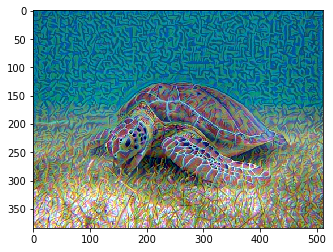

In [27]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

....................................................................................................

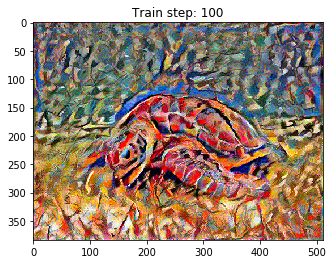

....................................................................................................

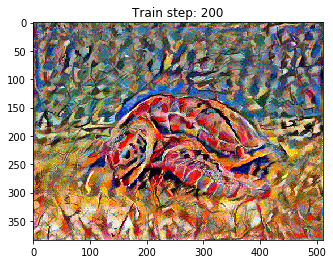

....................................................................................................

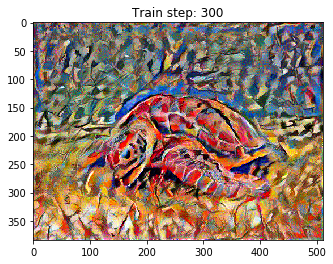

....................................................................................................

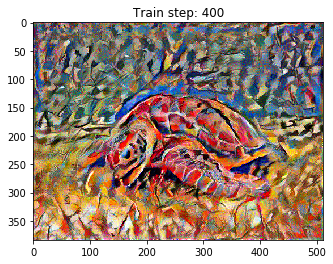

....................................................................................................

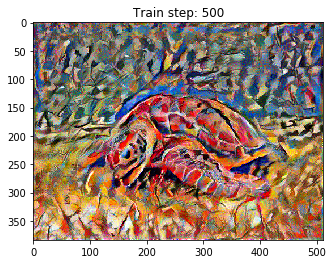

....................................................................................................

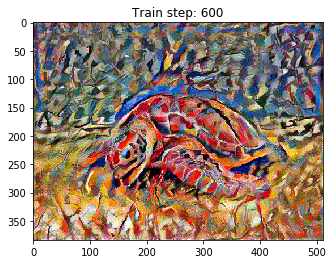

....................................................................................................

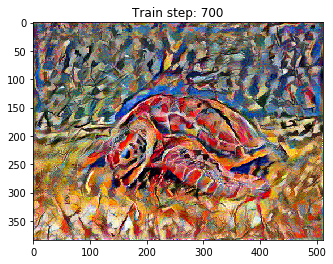

....................................................................................................

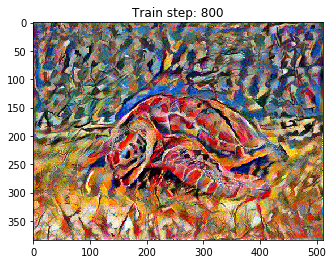

....................................................................................................

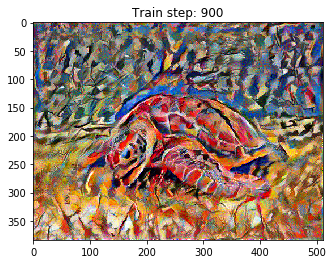

....................................................................................................

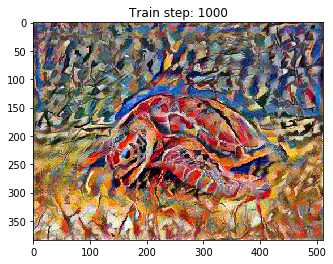

Total time: 209.7


In [31]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  #display.clear_output(wait=True)
  image_show(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))